In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/spectrumSmallDatasetJan15Final.csv')

In [ ]:
print(df.columns)


Index(['Unnamed: 0', 'Type', 'MCC', 'MNC', 'Freq', 'PCI', 'RSRP', 'RSRQ',
       'srxlex', 'squal/scs', 'cellid', 'TAC', 'Bandwidth', 'Band', 'Time',
       'Location', 'DLpower', 'ULpower', 'EndTime'],
      dtype='object')


In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
df.rename(columns={'Time': 'timestamp'}, inplace=True)


In [ ]:
# Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.sort_values(by='timestamp')


In [ ]:
print("🕵️‍♀️ Unparseable timestamps:", df['timestamp'].isna().sum())


🕵️‍♀️ Unparseable timestamps: 27


In [ ]:
df = df.dropna(subset=['timestamp'])


In [ ]:
df = df.sort_values(by='timestamp').reset_index(drop=True)


In [ ]:
# Extract time features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday


In [ ]:
df['RSRP'] = pd.to_numeric(df['RSRP'], errors='coerce')


In [ ]:
df = df.dropna(subset=['RSRP'])


In [ ]:
# Feature Engineering with RSRP
df['delta_rsrp'] = df['RSRP'].diff().fillna(0)
df['rolling_rsrp_mean'] = df['RSRP'].rolling(window=5, min_periods=1).mean()
df['rolling_rsrp_std'] = df['RSRP'].rolling(window=5, min_periods=1).std().fillna(0)
df['rsrp_trend'] = df['RSRP'] - df['rolling_rsrp_mean']


In [ ]:
# Labeling Activity
def classify_activity(row):
    if row['RSRP'] > -105 and row['delta_rsrp'] > -3:
        return 'Active'
    else:
        return 'Idle'

In [ ]:
df['activity'] = df.apply(classify_activity, axis=1)
df['activity_binary'] = df['activity'].map({'Active': 1, 'Idle': 0})


In [ ]:
# Optional: Save for next steps
df.to_csv("processed_base_station_data.csv", index=False)
print("✅ Done! Data processed and saved.")

✅ Done! Data processed and saved.


In [ ]:
# Define CustomPerceptron class
class CustomPerceptron:
    def __init__(self, learning_rate=0.01, max_iter=1000, random_state=42):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.errors_ = []

    def _step_function(self, x):
        return np.where(x >= 0, 1, 0)

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn()

        for _ in range(self.max_iter):
            errors = 0
            for xi, target in zip(X, y):
                prediction = self._step_function(np.dot(xi, self.weights) + self.bias)
                error = target - prediction
                if error != 0:
                    self.weights += self.learning_rate * error * xi
                    self.bias += self.learning_rate * error
                    errors += 1
            self.errors_.append(errors)
            if errors == 0:
                break
        return self

    def predict(self, X):
        return self._step_function(np.dot(X, self.weights) + self.bias)

In [ ]:
# Define CustomSVM class
class CustomSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, max_iter=1000, random_state=42):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.losses = []

    def _hinge_loss(self, y, y_pred):
        return np.maximum(0, 1 - y * y_pred)

    def fit(self, X, y):
        np.random.seed(self.random_state)
        y = np.where(y <= 0, -1, 1)
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn()

        for _ in range(self.max_iter):
            for idx, xi in enumerate(X):
                condition = y[idx] * (np.dot(xi, self.weights) + self.bias) >= 1
                if condition:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights - np.dot(xi, y[idx]))
                    self.bias -= self.learning_rate * y[idx]
            output = np.dot(X, self.weights) + self.bias
            loss = np.mean(self._hinge_loss(y, output))
            self.losses.append(loss)
        return self

    def predict(self, X):
        output = np.dot(X, self.weights) + self.bias
        return np.where(output <= 0, 0, 1)


In [ ]:
# Define CustomNeuralNetwork class
class CustomNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, max_iter=1000, random_state=42):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = []
        self.biases = []
        self.losses = []

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        sx = self._sigmoid(x)
        return sx * (1 - sx)

    def _initialize_parameters(self):
        np.random.seed(self.random_state)
        for i in range(len(self.layer_sizes) - 1):
            self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * 0.01)
            self.biases.append(np.random.randn(1, self.layer_sizes[i+1]) * 0.01)

    def _forward_propagation(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            net = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activations.append(self._sigmoid(net))
        return activations

    def _backward_propagation(self, X, y, activations):
        m = X.shape[0]
        deltas = []
        delta = activations[-1] - y.reshape(-1, 1)
        deltas.append(delta)
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[-1], self.weights[i].T) * self._sigmoid_derivative(activations[i])
            deltas.append(delta)
        deltas.reverse()
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * np.dot(activations[i].T, deltas[i]) / m
            self.biases[i] -= self.learning_rate * np.sum(deltas[i], axis=0, keepdims=True) / m

    def fit(self, X, y):
        self._initialize_parameters()
        y = y.reshape(-1, 1)
        for _ in range(self.max_iter):
            activations = self._forward_propagation(X)
            self._backward_propagation(X, y, activations)
            loss = np.mean(np.square(activations[-1] - y))
            self.losses.append(loss)
        return self

    def predict(self, X):
        activations = self._forward_propagation(X)
        return (activations[-1] >= 0.5).astype(int)


In [ ]:
# Load and validate CSV data
def load_and_validate_csv(file_path):
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} records")
    print(f"Columns: {df.columns.tolist()}")
    return df

In [ ]:
# Prepare data
def prepare_data(df):
    df['RSRP'] = pd.to_numeric(df['RSRP'], errors='coerce')
    if 'squal/scs' in df.columns:
        qual_column = 'squal/scs'
    else:
        raise ValueError("'squal/scs' column not found in the dataset.")
    df[qual_column] = pd.to_numeric(df[qual_column], errors='coerce')
    df = df.dropna(subset=['RSRP', qual_column])
    df['label'] = ((df['RSRP'] < -75) & (df[qual_column] < 22)).astype(int)
    X = df[['RSRP', qual_column]].values
    y = df['label'].values
    return X, y



In [ ]:
# Load data
df = load_and_validate_csv('/content/spectrumSmallDatasetJan15Final.csv')
X, y = prepare_data(df)

Loaded 437426 records
Columns: ['Unnamed: 0', 'Type', 'MCC', 'MNC', 'Freq', 'PCI', 'RSRP', 'RSRQ', 'srxlex', 'squal/scs', 'cellid', 'TAC', 'Bandwidth', 'Band', 'Time', 'Location', 'DLpower', 'ULpower', 'EndTime']


<ipython-input-6-a430bad2cbd4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = ((df['RSRP'] < -75) & (df[qual_column] < 22)).astype(int)


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Preprocess
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_test = scaler.transform(imputer.transform(X_test))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to safely convert to numeric
def safe_numeric_convert(x):
    if pd.isna(x) or x == '-' or x == '':
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

# Convert relevant columns to numeric type, replacing non-numeric values with NaN
numeric_columns = ['RSRP', 'squal']
for col in numeric_columns:
    if col in df.columns:
        df[col] = df[col].apply(safe_numeric_convert)

# Create a unique station ID
id_columns = [col for col in ['MCC', 'MNC', 'PCI'] if col in df.columns]
if id_columns:
    df['station_id'] = df[id_columns].astype(str).agg('_'.join, axis=1)
else:
    df['station_id'] = df.index.astype(str)

# Function to create target variable for idle stations
def create_idle_labels(df, rsrp_threshold=-75, squal_threshold=22):
    conditions = []
    if 'RSRP' in df.columns:
        conditions.append(df['RSRP'].notna() & (df['RSRP'] < rsrp_threshold))
    if 'squal' in df.columns:
        conditions.append(df['squal'].notna() & (df['squal'] < squal_threshold))

    if conditions:
        return (pd.concat(conditions, axis=1).all(axis=1)).astype(int)
    return pd.Series(0, index=df.index)

# Prepare data for Random Forest
def prepare_data_for_model(df):
    # Select numeric columns for features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'idle']  # Exclude target variable if present

    if len(numeric_cols) < 2:
        print("Not enough numeric features for prediction")
        return None, None, None, None, None

    # Create feature matrix X
    X = df[numeric_cols].copy()

    # Create target variable y
    y = create_idle_labels(df)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    return X_train_scaled, X_test_scaled, y_train, y_test, numeric_cols, imputer, scaler



In [ ]:
# Train and evaluate Random Forest model
def train_and_evaluate_model(X_train, X_test, y_train, y_test, feature_names):
    # Initialize and train the model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Print model performance
    print("\nModel Performance:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return rf_model

Training Random Forest model for base station prediction...

Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18578
           1       1.00      1.00      1.00      9478

    accuracy                           1.00     28056
   macro avg       1.00      1.00      1.00     28056
weighted avg       1.00      1.00      1.00     28056



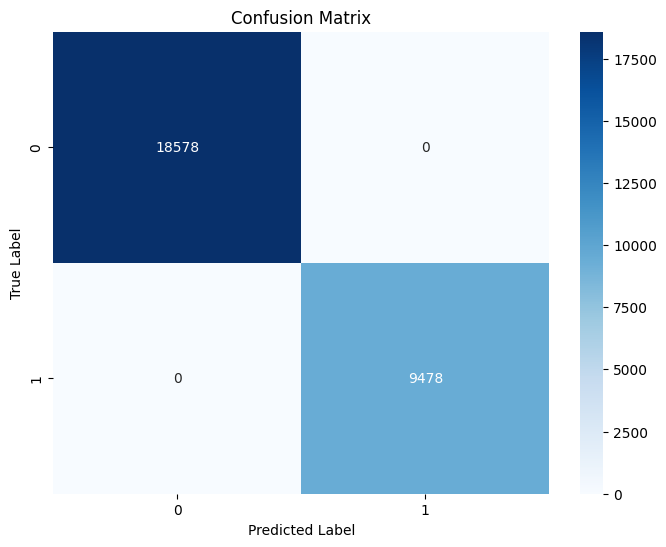

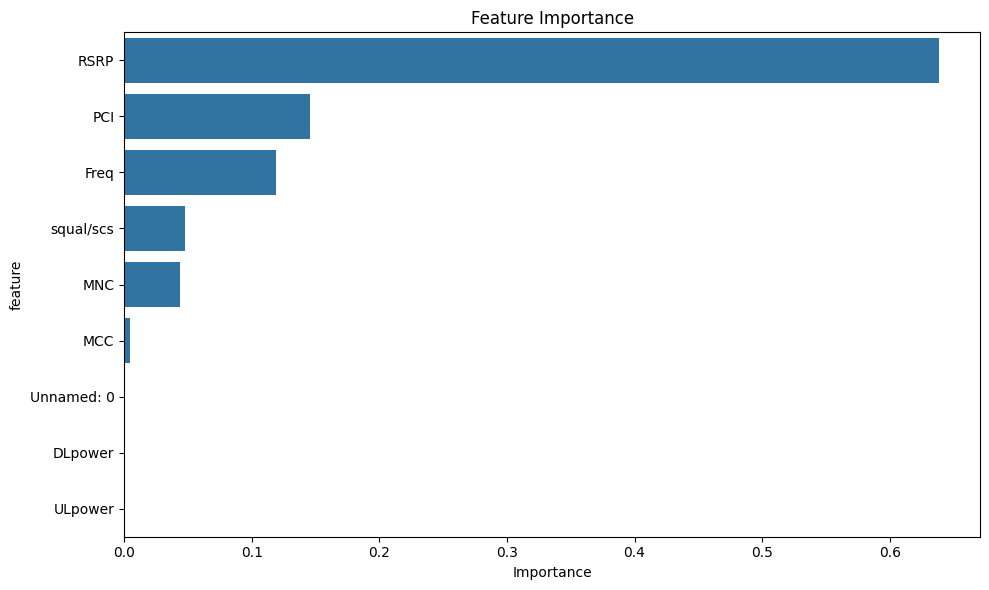

Streaming output truncated to the last 5000 lines.
- 310_410_334
- 310_410_486
- 310_410_334
- 310_260_434
- 310_260_434
- 313_100_211
- 310_260_434
- 310_260_434
- 313_100_211
- 310_260_434
- 310_260_434
- 310_410_211
- 313_100_389
- 313_100_486
- 310_410_389
- 310_410_334
- 310_410_211
- 310_410_180
- 313_100_334
- 310_410_486
- 313_100_389
- 313_100_389
- 310_260_434
- 313_100_486
- 313_100_486
- 310_260_434
- 310_410_389
- 310_410_416
- 313_100_389
- 313_100_486
- 310_410_211
- 310_410_211
- 313_100_211
- 310_410_211
- 310_260_434
- 310_410_389
- 313_100_211
- 310_410_389
- 310_410_486
- 310_410_180
- 313_100_389
- 310_410_389
- 313_100_211
- 310_260_434
- 310_260_434
- 310_410_334
- 313_100_211
- 313_100_334
- 310_260_434
- 313_100_486
- 313_100_486
- 313_100_211
- 313_100_355
- 310_410_389
- 310_260_434
- 310_260_434
- 310_410_211
- 310_410_211
- 310_410_389
- 310_260_434
- 313_100_389
- 313_100_211
- 310_410_486
- 313_100_486
- 313_100_389
- 310_260_434
- 313_100_211
- 310_410_4

In [ ]:
# Function to predict idle stations using the trained model
def predict_idle_stations_rf(model, df, feature_names, imputer, scaler):
    X = df[feature_names].copy()
    X_imputed = imputer.transform(X)
    X_scaled = scaler.transform(X_imputed)
    predictions = model.predict(X_scaled)

    return df[predictions == 1]['station_id'].tolist()

# Main execution
print("Training Random Forest model for base station prediction...")
X_train, X_test, y_train, y_test, feature_names, imputer, scaler = prepare_data_for_model(df)

if X_train is not None:
    # Train the model and get predictions
    rf_model = train_and_evaluate_model(X_train, X_test, y_train, y_test, feature_names)

    # Simulate time-based prediction
    print("\nSimulated Time-based Prediction using Random Forest:")
    time_periods = ['Morning', 'Afternoon', 'Evening', 'Night']
    for period in time_periods:
        print(f"\n{period}:")
        sample = df.sample(frac=0.5, replace=True)
        idle_stations = predict_idle_stations_rf(
            rf_model,
            sample,
            feature_names,
            imputer,
            scaler
        )
        for station in idle_stations:
            print(f"- {station}")
else:
    print("Could not perform Random Forest analysis due to insufficient numeric features.")


In [ ]:
# Train models
models = [
    (CustomPerceptron(), "Perceptron"),
    (CustomSVM(), "SVM"),
    (CustomNeuralNetwork([X_train.shape[1], 10, 5, 1]), "Neural Network")
]

In [ ]:
# After training the models, store them
trained_models = {}
available_columns = ['RSRP', 'squal/scs']


Training Perceptron...

Perceptron Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26593
           1       1.00      1.00      1.00      1132

    accuracy                           1.00     27725
   macro avg       1.00      1.00      1.00     27725
weighted avg       1.00      1.00      1.00     27725



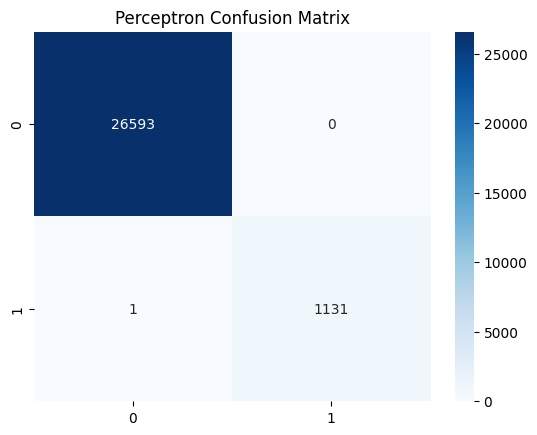

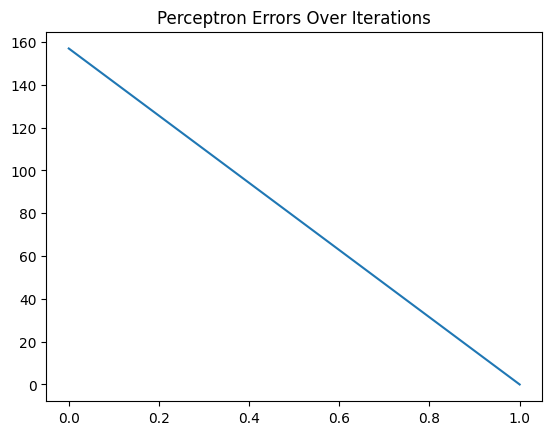

Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



SVM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     26593
           1       0.04      1.00      0.08      1132

    accuracy                           0.04     27725
   macro avg       0.02      0.50      0.04     27725
weighted avg       0.00      0.04      0.00     27725



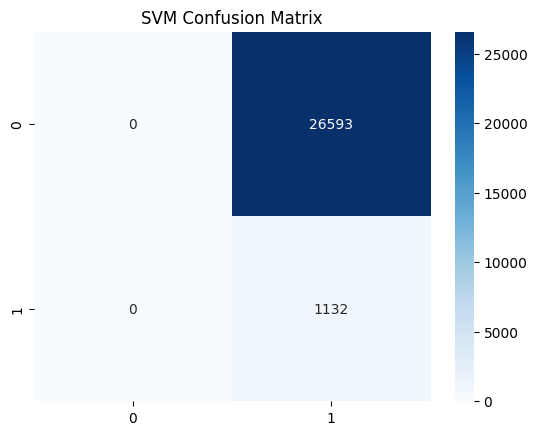

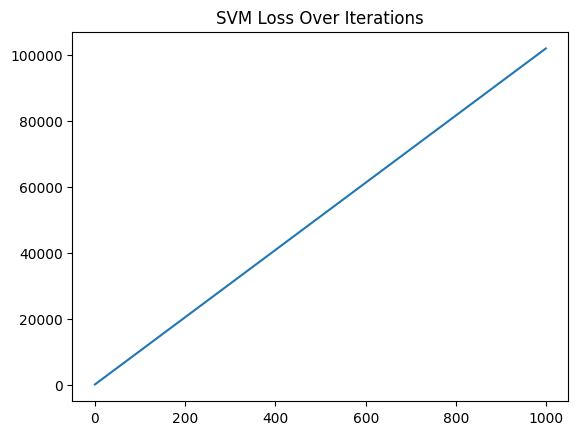

Training Neural Network...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     26593
           1       0.00      0.00      0.00      1132

    accuracy                           0.96     27725
   macro avg       0.48      0.50      0.49     27725
weighted avg       0.92      0.96      0.94     27725



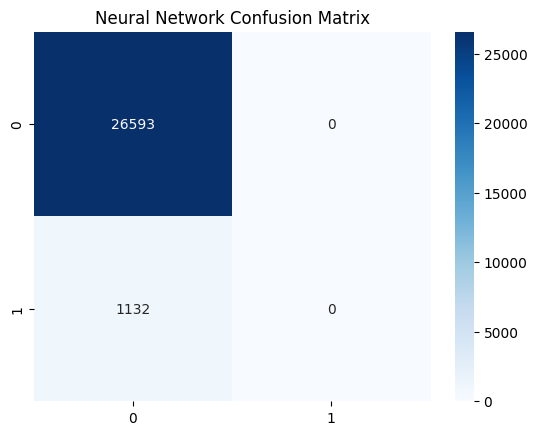

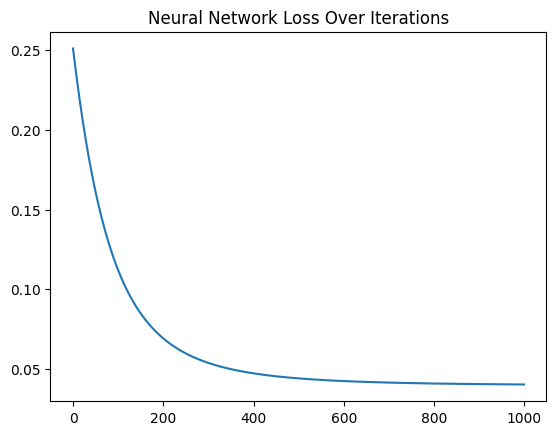

In [ ]:
for model, name in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    if hasattr(model, 'errors_'):
        plt.plot(model.errors_)
        plt.title(f'{name} Errors Over Iterations')
        plt.show()
    if hasattr(model, 'losses'):
        plt.plot(model.losses)
        plt.title(f'{name} Loss Over Iterations')
        plt.show()

    trained_models[name] = model



In [ ]:
# Define the function to predict idle stations
def predict_idle_stations(model, sample, available_columns, imputer, scaler):
    sample_features = sample[available_columns].copy()
    sample_features = scaler.transform(imputer.transform(sample_features))
    predictions = model.predict(sample_features)
    idle_stations = sample[predictions == 1]  # Assuming label 1 means idle
    return idle_stations.index.tolist()

In [ ]:
# Time-based predictions
try:
    print("\nTime-based Predictions:")
    for period in ['Morning', 'Afternoon', 'Evening', 'Night']:
        print(f"\n{period}:")
        sample = df.sample(n=min(len(df), 10000), replace=False)

        for model_name, model in trained_models.items():
            print(f"\n{model_name} predictions:")
            idle_stations = predict_idle_stations(
                model,
                sample,
                available_columns,
                imputer,
                scaler
            )
            print(f"Number of idle stations: {len(idle_stations)}")
            for station in idle_stations[:5]:
                print(f"- Station Index: {station}")
            if len(idle_stations) > 5:
                print(f"... and {len(idle_stations) - 5} more stations")
except Exception as e:
    print(f"Error during processing: {str(e)}")
    print("Please check your data format and column names")



Time-based Predictions:

Morning:

Perceptron predictions:
Number of idle stations: 525
- Station Index: 77685
- Station Index: 86118
- Station Index: 114562
- Station Index: 130889
- Station Index: 103197
... and 520 more stations

SVM predictions:
Number of idle stations: 10000
- Station Index: 97514
- Station Index: 97134
- Station Index: 32422
- Station Index: 93071
- Station Index: 115969
... and 9995 more stations

Neural Network predictions:
Number of idle stations: 0

Afternoon:

Perceptron predictions:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Number of idle stations: 506
- Station Index: 118316
- Station Index: 123910
- Station Index: 115278
- Station Index: 120563
- Station Index: 115006
... and 501 more stations

SVM predictions:
Number of idle stations: 10000
- Station Index: 52143
- Station Index: 104517
- Station Index: 11835
- Station Index: 123476
- Station Index: 10841
... and 9995 more stations

Neural Network predictions:
Number of idle stations: 0

Evening:

Perceptron predictions:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Number of idle stations: 524
- Station Index: 125565
- Station Index: 9082
- Station Index: 33630
- Station Index: 119536
- Station Index: 82575
... and 519 more stations

SVM predictions:
Number of idle stations: 10000
- Station Index: 106862
- Station Index: 118231
- Station Index: 43049
- Station Index: 23731
- Station Index: 45214
... and 9995 more stations

Neural Network predictions:
Number of idle stations: 0

Night:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(



Perceptron predictions:
Number of idle stations: 486
- Station Index: 93594
- Station Index: 122695
- Station Index: 56887
- Station Index: 118788
- Station Index: 66359
... and 481 more stations

SVM predictions:
Number of idle stations: 10000
- Station Index: 137316
- Station Index: 93594
- Station Index: 83370
- Station Index: 19877
- Station Index: 139927
... and 9995 more stations

Neural Network predictions:
Number of idle stations: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [ ]:
# Option 1: Print the entire file (if it's not too large)
with open("train.txt", "r", encoding="utf-8") as file:
    content = file.read()
    print(content)

# Option 2: Print just the first 20 lines (better for large files)
print("\n--- First 20 lines of train.txt: ---\n")
with open("train.txt", "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        if i < 20:  # Only print first 20 lines
            print(f"{i+1}: {line.strip()}")
        else:
            break

    # Count total lines in file
    file.seek(0)  # Go back to beginning of file
    total_lines = sum(1 for _ in file)
    print(f"\nTotal lines in file: {total_lines}")

Streaming output truncated to the last 5000 lines.
my O
birthday :red_heart:
️ O
<STOP> O

<START> O
Get O
this O
to O
2000 O
Retweets O
and O
1000 O
Replies O
in O
just O
3 O
hours :fire:
<STOP> O

<START> O
You O
think O
u O
slick :face_with_rolling_eyes:
<STOP> O

<START> O
My O
week O
on O
Twitter :party_popper:
1 O
Mention O
3 O
Likes O
1 O
Retweet O
95 O
Retweet O
Reach O
6 O
New O
Followers O
1 O
Reply O
See O
yours O
with O
… O
<STOP> O

<START> O
And O
here O
we O
go O
blaming O
the O
woman :face_with_rolling_eyes:
<STOP> O

<START> O
Not O
going O
to O
the O
gym O
anymore O
Just O
invested O
in O
a O
bowflex :flexed_biceps:
🏼 :fire:
<STOP> O

<START> O
SOB :loudly_crying_face:
hes O
so O
beautiful O
<STOP> O

<START> O
Texting O
everyday O
doesnt O
make O
you O
a O
better O
friend O
some O
of O
you O
dier O
yie :person_facepalming:
🏻 O
‍ :female_sign:
️ :person_facepalming:
🏻 O
‍ :female_sign:
️ O
<STOP> O

<START> O
I O
shed O
a O
tear O
or O
2 O
every O
single O
time O
this